In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [41]:
from drone_sar.ipsar_dataset import IPSARDataset
from drone_sar.lightning_detector import get_lightning_trainer, LightningDetector
from collections import Counter
from drone_sar.vis import show_detections

In [5]:
train_data = IPSARDataset("../heridal/trainImages/")
test_data = IPSARDataset("../heridal/testImages")
item = test_data[0]

In [6]:
trainer = get_lightning_trainer("IPSAR-DETR-FIXED", max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# best_model_path = "/home/iz/workspace/DroneSearchAndRescue/notebooks/.checkpoints/epoch=88-step=14151.ckpt"
best_model_path = "/home/iz/workspace/DroneSearchAndRescue/notebooks/.checkpoints/epoch=65-step=10494.ckpt"

In [8]:
best_model = LightningDetector.load_from_checkpoint(best_model_path, lr=0.01)

/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
test_dl_b1 = test_data.get_dataloader(best_model.processor, bs=1, shuffle=False)
train_dl_b1 = train_data.get_dataloader(best_model.processor, bs=1, shuffle=False)

In [10]:
best_val_outputs = trainer.predict(best_model, test_dl_b1)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

In [11]:
best_train_outputs = trainer.predict(best_model, train_dl_b1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

In [12]:
best_train_outputs[0].keys()

odict_keys(['loss', 'loss_dict', 'logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [42]:
pil = test_data[1]["pil"]

In [43]:
boxes = best_model.predict(pil)

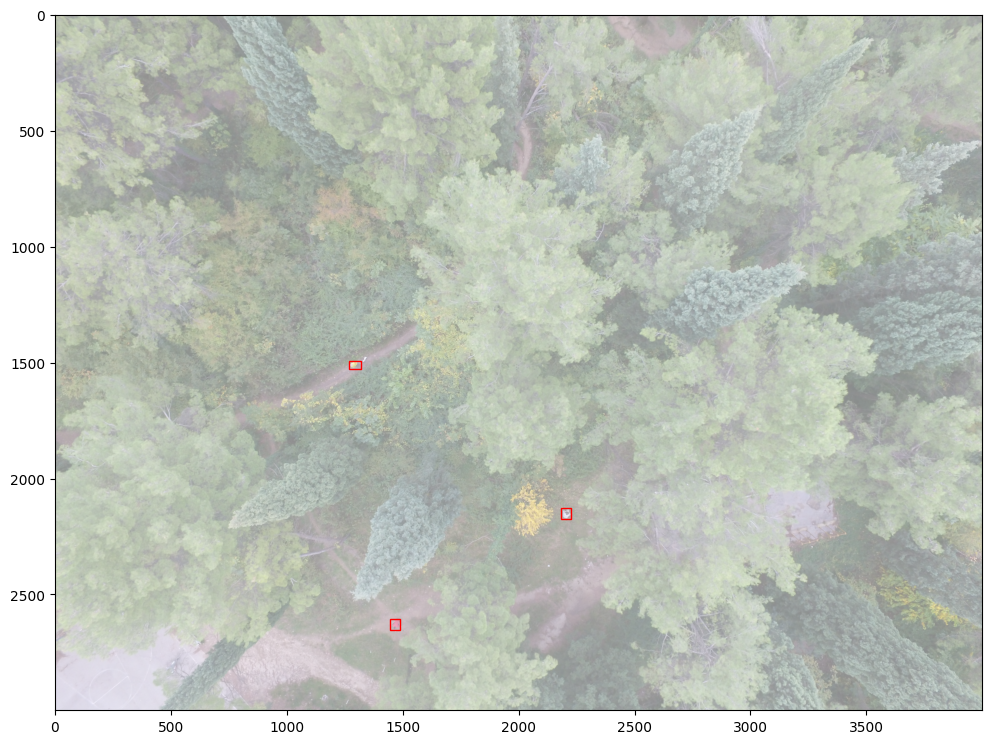

In [44]:
plt_show(pil, colored_boxes_dict={"red": boxes})